In [19]:
from statsmodels.formula.api import ols
from statsmodels.stats import anova
import pingouin as pg
import pandas as pd
import numpy as np
from scipy.stats import normaltest

data = pd.read_csv('../03-cleaning/for-anova/anova-data.csv')
data = data.query('salary_low > 10000') #load data, data with salaries lower than 10000 are incorrectly labeled or unlabeled
data = data.query('role != "unknown"')
data[['is_remote','is_intern','role','seniority']] = data[['is_remote','is_intern','role','seniority']].apply(pd.Categorical) #set dtypes
data = data[['salary_avg','is_remote','is_intern','role']]
data

,salary_avg,is_remote,is_intern,role
0,45500.0,Y,1,analyst
1,70000.0,N,0,analyst
2,158000.0,Y,0,scientist
3,120000.0,N,0,scientist
4,84000.0,Y,0,scientist
...,...,...,...,...
607,83500.0,Y,0,engineer
608,135500.0,Y,0,scientist
610,117000.0,N,0,engineer
614,130000.0,Y,0,scientist


# Questions:
* Does mean salary differ between job title?
* Does mean salary differ between remote and in-person jobs?
* Does mean salary differ between co-op's and internships?
* Does the interaction of these factors affect salary?
* Can we predict the salary of these jobs

Thus we will try to perform ANOVA.

Let's check the assumptions

# Normality

Though simulation studies have shown that ANOVA is fairly resistant to departures from normality given large N, we will test it anyways


NormaltestResult(statistic=59.61652519691627, pvalue=1.1335378816351192e-13)

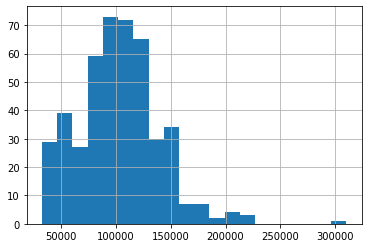

In [20]:
data.salary_avg.hist(bins=20)
normaltest(data.salary_avg)

The data looks fairly normal with some rightward skew and outliers. We will say the assumption is met and proceed

# Group Counts

Though not a strict assumption of ANOVA, we should make sure our groups are not too small

In [40]:
pd.DataFrame(data.groupby(['role','is_intern','is_remote']).salary_avg.count().rename('count'))


count
role      is_intern is_remote       
analyst   0         N             29
                    Y             31
          1         N             16
                    Y              6
engineer  0         N             46
                    Y             47
          1         N             10
                    Y              1
scientist 0         N            132
                    Y             81
          1         N             42
                    Y             11

hmmm looks like there's only one remote intern engineer. This could be a problem. For now let's drop the remote factor since it is less interesting and proceed with a two-way anova.

In [42]:
pd.DataFrame(data.groupby(['role','is_intern']).salary_avg.count().rename('count'))

count
role      is_intern       
analyst   0             60
          1             22
engineer  0             93
          1             11
scientist 0            213
          1             53

much better

# Equal Variances

Let's make take a look at the within group variances:

In [45]:
stds = pd.DataFrame(data.groupby(['role','is_intern']).salary_avg.std().rename('std'))
stds

std
role      is_intern              
analyst   0          30618.178565
          1          19864.380552
engineer  0          25762.690577
          1          18336.377158
scientist 0          34091.064209
          1          20229.515791

In [46]:
stds.max()/stds.min()

std    1.859204
dtype: float64

The maximum standard deviation is no more than twice the minimum. The equal variances assumption is met.

The independence assumption seems reasonable. We proceed with ANOVA.

#ANOVA

Null Hypotheses:

* Mean salary does not differ between roles
* Mean salary does not differ between is_intern
* There is no interaction effect between role and is_intern

In [52]:
anova = pg.anova(data=data,dv='salary_avg',between=['role','is_intern'],ss_type=3)
anova = anova.set_index('Source')
anova

,SS,DF,MS,F,p-unc,np2
Source,,,,,,
role,1.113111e+10,2.0,5.565555e+09,6.273216,2.056806e-03,0.027361
is_intern,1.035486e+11,1.0,1.035486e+11,116.714796,2.525552e-24,0.207414
role * is_intern,6.144753e+09,2.0,3.072376e+09,3.463030,3.217982e-02,0.015292
Residual,3.956882e+11,446.0,8.871932e+08,NaN,NaN,NaN


That's what we like to see. The p-values are all indicating significant differences between at least one pair of levels in each factor. There also appears to be an interaction effect. We will proceed with pairwise ttests to identify specific differences.

In [60]:
ttest = pg.pairwise_tests(data=data,dv='salary_avg',between=['role','is_intern'])

ttest

,Contrast,role,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,role,-,analyst,scientist,False,True,-4.966903,159.161412,two-sided,1.738572e-06,1.249e+04,-0.568996
1,role,-,analyst,engineer,False,True,-5.670162,158.364910,two-sided,6.595236e-08,2.093e+05,-0.850719
2,role,-,scientist,engineer,False,True,-1.117746,265.229642,two-sided,2.646870e-01,0.231,-0.111165
3,is_intern,-,1,0,False,True,-19.192684,199.742355,two-sided,3.213542e-47,4.369e+56,-1.742517
4,role * is_intern,analyst,1,0,False,True,-6.817196,57.887661,two-sided,5.990726e-09,4.982e+06,-1.387531
5,role * is_intern,scientist,1,0,False,True,-16.355582,134.931611,two-sided,8.035138e-34,2.385e+38,-1.859321
6,role * is_intern,engineer,1,0,False,True,-6.582161,15.125305,two-sided,8.347537e-06,3.235e+06,-1.596306


It appears that the only groups that do not have a significant difference in mean salary are data scientists and data engineers. We will use this information to construct a ranking.

In [58]:
pd.DataFrame(data.groupby(['role','is_intern']).salary_avg.mean().rename('mean')).sort_values(by='mean')

,,mean
role,is_intern,
analyst,1,54886.363636
scientist,1,58047.169811
engineer,1,73545.454545
analyst,0,94379.425000
engineer,0,113961.446237
scientist,0,117419.791080


Unsurprisingly interns earn the least.